In [1]:
!pip install transformers datasets accelerate evaluate peft bitsandbytes --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 23.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.4 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This

In [2]:
import os
import torch
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
from tqdm import tqdm
from datasets import load_dataset, Dataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, AutoTokenizer, AutoModelForSequenceClassification
from peft import LoraConfig, get_peft_model, TaskType
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from torch.utils.data import DataLoader

2025-04-21 23:26:48.975180: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745278009.210914      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745278009.278796      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
base_model = 'roberta-base'
dataset = load_dataset('ag_news', split='train')
tokenizer = RobertaTokenizer.from_pretrained(base_model)

def preprocess(examples):
    return tokenizer(examples['text'], truncation=True, padding=True)

tokenized_dataset = dataset.map(preprocess, batched=True, remove_columns=["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

In [4]:
split_datasets = tokenized_dataset.train_test_split(test_size=640, seed=42)
train_dataset = split_datasets['train']
eval_dataset = split_datasets['test']

id2label = {i: label for i, label in enumerate(['World', 'Sports', 'Business', 'Sci/Tech'])}
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

In [5]:
model = RobertaForSequenceClassification.from_pretrained(
    base_model,
    num_labels=4,
    id2label=id2label
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
peft_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias='none',
    target_modules=['query', 'value'],
    task_type="SEQ_CLS"
)

peft_model = get_peft_model(model, peft_config)
peft_model.print_trainable_parameters()

trainable params: 888,580 || all params: 125,537,288 || trainable%: 0.7078


In [7]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {'accuracy': accuracy_score(labels, preds)}

In [8]:
training_args = TrainingArguments(
    output_dir="results",
    # optimiser & LR
    learning_rate      = 5e-5,            # a bit higher—LoRA learns fast
    warmup_ratio       = 0.1,             # 10 % linear warm‑up
    lr_scheduler_type  = "linear",
    weight_decay       = 0.01,            # regularise classifier head

    # batch / epochs
    per_device_train_batch_size = 16,
    gradient_accumulation_steps = 4,      # effective BS = 64
    per_device_eval_batch_size  = 128,
    num_train_epochs            = 4,      # small extra epoch often +1 %
    max_grad_norm              = 1.0,     # gradient clipping

    # precision & speed
    fp16 = True,                          # or bf16 on A100/H100
    logging_dir = "logs",
    logging_steps = 50,
    eval_strategy = "epoch",
    save_strategy        = "epoch",       # keep best checkpoint
    load_best_model_at_end = True,
    metric_for_best_model = "accuracy",
    report_to = "none"
)


In [9]:
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

/tmp/ipykernel_31/1218511061.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [11]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.248700,0.285277,0.907813
2,0.242100,0.244235,0.923438
3,0.186600,0.235480,0.921875
4,0.204000,0.228116,0.923438


TrainOutput(global_step=7460, training_loss=0.2753506938989297, metrics={'train_runtime': 11448.3899, 'train_samples_per_second': 41.704, 'train_steps_per_second': 0.652, 'total_flos': 8.153348496494592e+16, 'train_loss': 0.2753506938989297, 'epoch': 4.0})

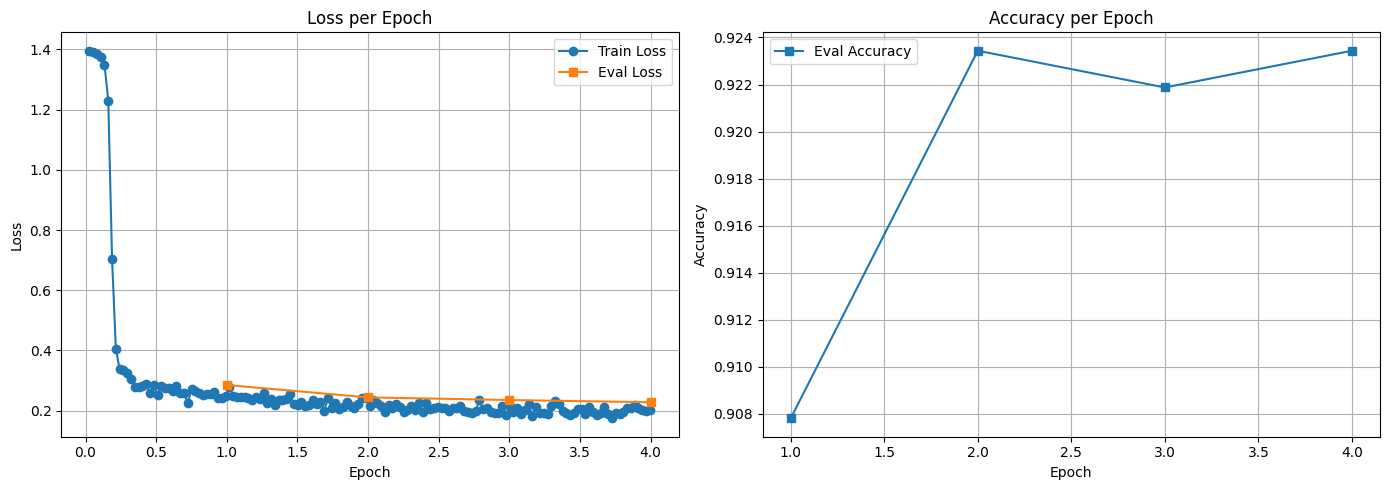

In [14]:
# ----------------  LOG CURVES  ----------------
# Converting the Trainer's log history into a DataFrame
log_df = pd.DataFrame(trainer.state.log_history)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# ── Loss ────────────────────────────────────────────────────────────────
if "loss" in log_df.columns:
    train_loss = log_df[["epoch", "loss"]].dropna()
    ax[0].plot(train_loss["epoch"], train_loss["loss"],
               marker="o", label="Train Loss")

if "eval_loss" in log_df.columns:
    eval_loss = log_df[["epoch", "eval_loss"]].dropna()
    ax[0].plot(eval_loss["epoch"], eval_loss["eval_loss"],
               marker="s", label="Eval Loss")

ax[0].set_title("Loss per Epoch")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[0].grid(True)

# ── Accuracy ────────────────────────────────────────────────────────────
if "accuracy" in log_df.columns:
    train_acc = log_df[["epoch", "accuracy"]].dropna()
    ax[1].plot(train_acc["epoch"], train_acc["accuracy"],
               marker="o", label="Train Accuracy")

if "eval_accuracy" in log_df.columns:
    eval_acc  = log_df[["epoch", "eval_accuracy"]].dropna()
    ax[1].plot(eval_acc["epoch"], eval_acc["eval_accuracy"],
               marker="s", label="Eval Accuracy")

ax[1].set_title("Accuracy per Epoch")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()


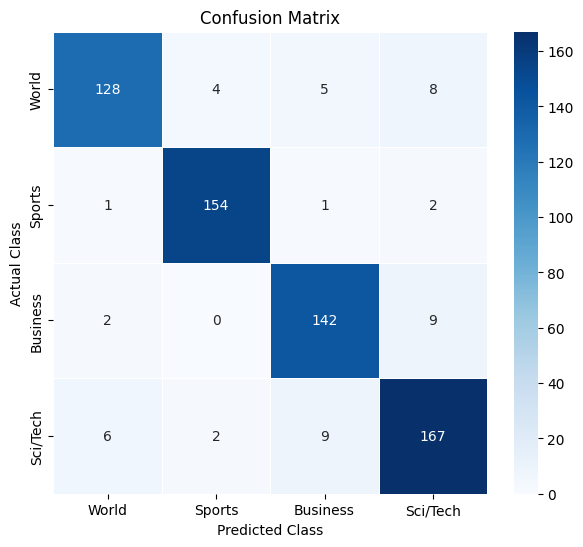

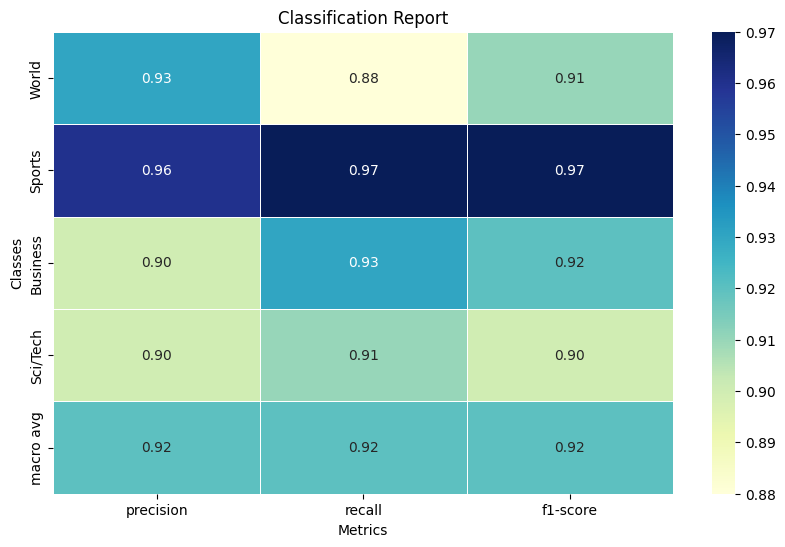


Detailed numbers:
               precision    recall  f1-score   support

       World       0.93      0.88      0.91       145
      Sports       0.96      0.97      0.97       158
    Business       0.90      0.93      0.92       153
    Sci/Tech       0.90      0.91      0.90       184

    accuracy                           0.92       640
   macro avg       0.92      0.92      0.92       640
weighted avg       0.92      0.92      0.92       640



In [16]:
# ----------------  CONFUSION MATRIX & REPORT  ----------------
# Get predictions on the validation split
pred_output = trainer.predict(eval_dataset)
y_true = pred_output.label_ids
y_pred = pred_output.predictions.argmax(axis=1)

# ‑‑ Confusion Matrix ‑‑
cm = confusion_matrix(y_true, y_pred)

cm_df = pd.DataFrame(cm,
                     index=[id2label[i] for i in range(len(id2label))],
                     columns=[id2label[i] for i in range(len(id2label))])

plt.figure(figsize=(7, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", linewidths=.5)
plt.title("Confusion Matrix")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
plt.show()

# ‑‑ Classification Report (heat‑map flavour) ‑‑
report = classification_report(y_true,
                               y_pred,
                               target_names=[id2label[i] for i in range(len(id2label))],
                               output_dict=True)

report_df = (pd.DataFrame(report).transpose()      # precision / recall / f1 / support
               .drop("accuracy", errors="ignore")  # remove scalar accuracy row
               .round(2))

plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :-1],   # skip support column for cleaner view
            annot=True, cmap="YlGnBu", fmt=".2f", linewidths=.5)
plt.title("Classification Report")
plt.ylabel("Classes")
plt.xlabel("Metrics")
plt.show()

print("\nDetailed numbers:\n", classification_report(
      y_true, y_pred, target_names=[id2label[i] for i in range(len(id2label))]))


In [17]:
with open("/kaggle/input/deep-learning-spring-2025-project-2/test_unlabelled.pkl", "rb") as f: 
    unlabeled_dataset = pickle.load(f)

test_dataset = unlabeled_dataset
test_dataset = test_dataset.map(preprocess, batched=True, remove_columns=["text"])

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

In [18]:

eval_results = trainer.evaluate()
print("Final Evaluation Accuracy:", eval_results["eval_accuracy"])

Final Evaluation Accuracy: 0.9234375


In [19]:
def evaluate_model(inference_model, dataset, batch_size=8):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    inference_model.to("cuda" if torch.cuda.is_available() else "cpu")
    inference_model.eval()
    all_preds = []
    
    for batch in tqdm(dataloader):
        batch = {k: v.to(inference_model.device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = inference_model(**batch)
        preds = outputs.logits.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
    return all_preds

preds = evaluate_model(peft_model, test_dataset)

df_output = pd.DataFrame({
    'ID': range(len(preds)),
    'Label': preds
})
df_output.to_csv("submission.csv", index=False)

100%|██████████| 1000/1000 [01:04<00:00, 15.56it/s]
